In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
df=pd.read_csv('/content/sales_data_sample.csv', encoding='latin1', lineterminator='\n')

In [ ]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [ ]:
def wrangle(path):
  df=pd.read_csv(path, encoding='latin1')
  df.dropna(axis=1, inplace=True)
  df= df[['QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','SALES','ORDERDATE','PRODUCTLINE','MSRP','COUNTRY','DEALSIZE']]
  df['sale_year']=df['ORDERDATE'].dt.year
  df['sale_month']=df['ORDERDATE'].dt.month
  df['sale_day']=df['ORDERDATE'].dt.day
  df.drop('ORDERDATE', axis=1, inplace=True)
  return df

In [ ]:
df.info()
df.columns
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0


In [ ]:
df.dropna(axis=1, inplace=True)
df_saling_record=df[['QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','SALES','ORDERDATE','PRODUCTLINE','MSRP','COUNTRY','DEALSIZE']]
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,Motorcycles,95,USA,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Motorcycles,95,France,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Motorcycles,95,France,Medium
3,45,83.26,6,3746.70,8/25/2003 0:00,Motorcycles,95,USA,Medium
4,49,100.00,14,5205.27,10/10/2003 0:00,Motorcycles,95,USA,Medium


In [ ]:
df_saling_record['PRODUCTLINE'].value_counts()

,count
PRODUCTLINE,
Classic Cars,967
Vintage Cars,607
Motorcycles,331
Planes,306
Trucks and Buses,301
Ships,234
Trains,77


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_saling_record['ORDERDATE']= pd.to_datetime(df_saling_record['ORDERDATE'])
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE,sale_year,sale_month,sale_day
0,30,95.70,2,2871.00,2003-02-24,Motorcycles,95,USA,Small,2003,2,24
1,34,81.35,5,2765.90,2003-05-07,Motorcycles,95,France,Small,2003,5,7
2,41,94.74,2,3884.34,2003-07-01,Motorcycles,95,France,Medium,2003,7,1
3,45,83.26,6,3746.70,2003-08-25,Motorcycles,95,USA,Medium,2003,8,25
4,49,100.00,14,5205.27,2003-10-10,Motorcycles,95,USA,Medium,2003,10,10


# Sales Distribution

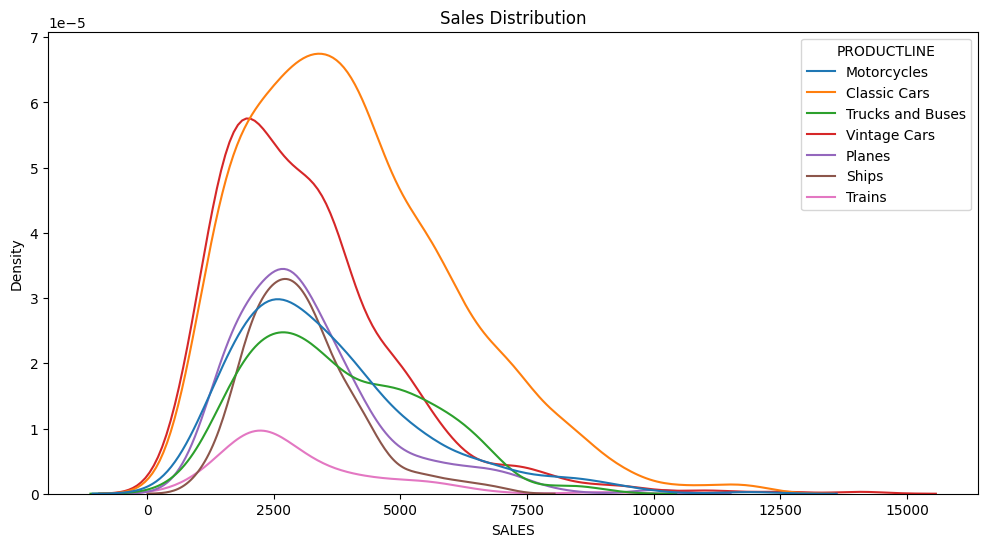

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df_saling_record, x='SALES', hue='PRODUCTLINE')
plt.title('Sales Distribution')
plt.show()

# Extract time based features

In [ ]:
df_saling_record['sale_year']=df_saling_record['ORDERDATE'].dt.year
df_saling_record['sale_month']=df_saling_record['ORDERDATE'].dt.month
df_saling_record['sale_day']=df_saling_record['ORDERDATE'].dt.day
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE,sale_year,sale_month,sale_day
0,30,95.70,2,2871.00,2003-02-24,Motorcycles,95,USA,Small,2003,2,24
1,34,81.35,5,2765.90,2003-05-07,Motorcycles,95,France,Small,2003,5,7
2,41,94.74,2,3884.34,2003-07-01,Motorcycles,95,France,Medium,2003,7,1
3,45,83.26,6,3746.70,2003-08-25,Motorcycles,95,USA,Medium,2003,8,25
4,49,100.00,14,5205.27,2003-10-10,Motorcycles,95,USA,Medium,2003,10,10


# Yearly, Montly, Daily Sales Distribution

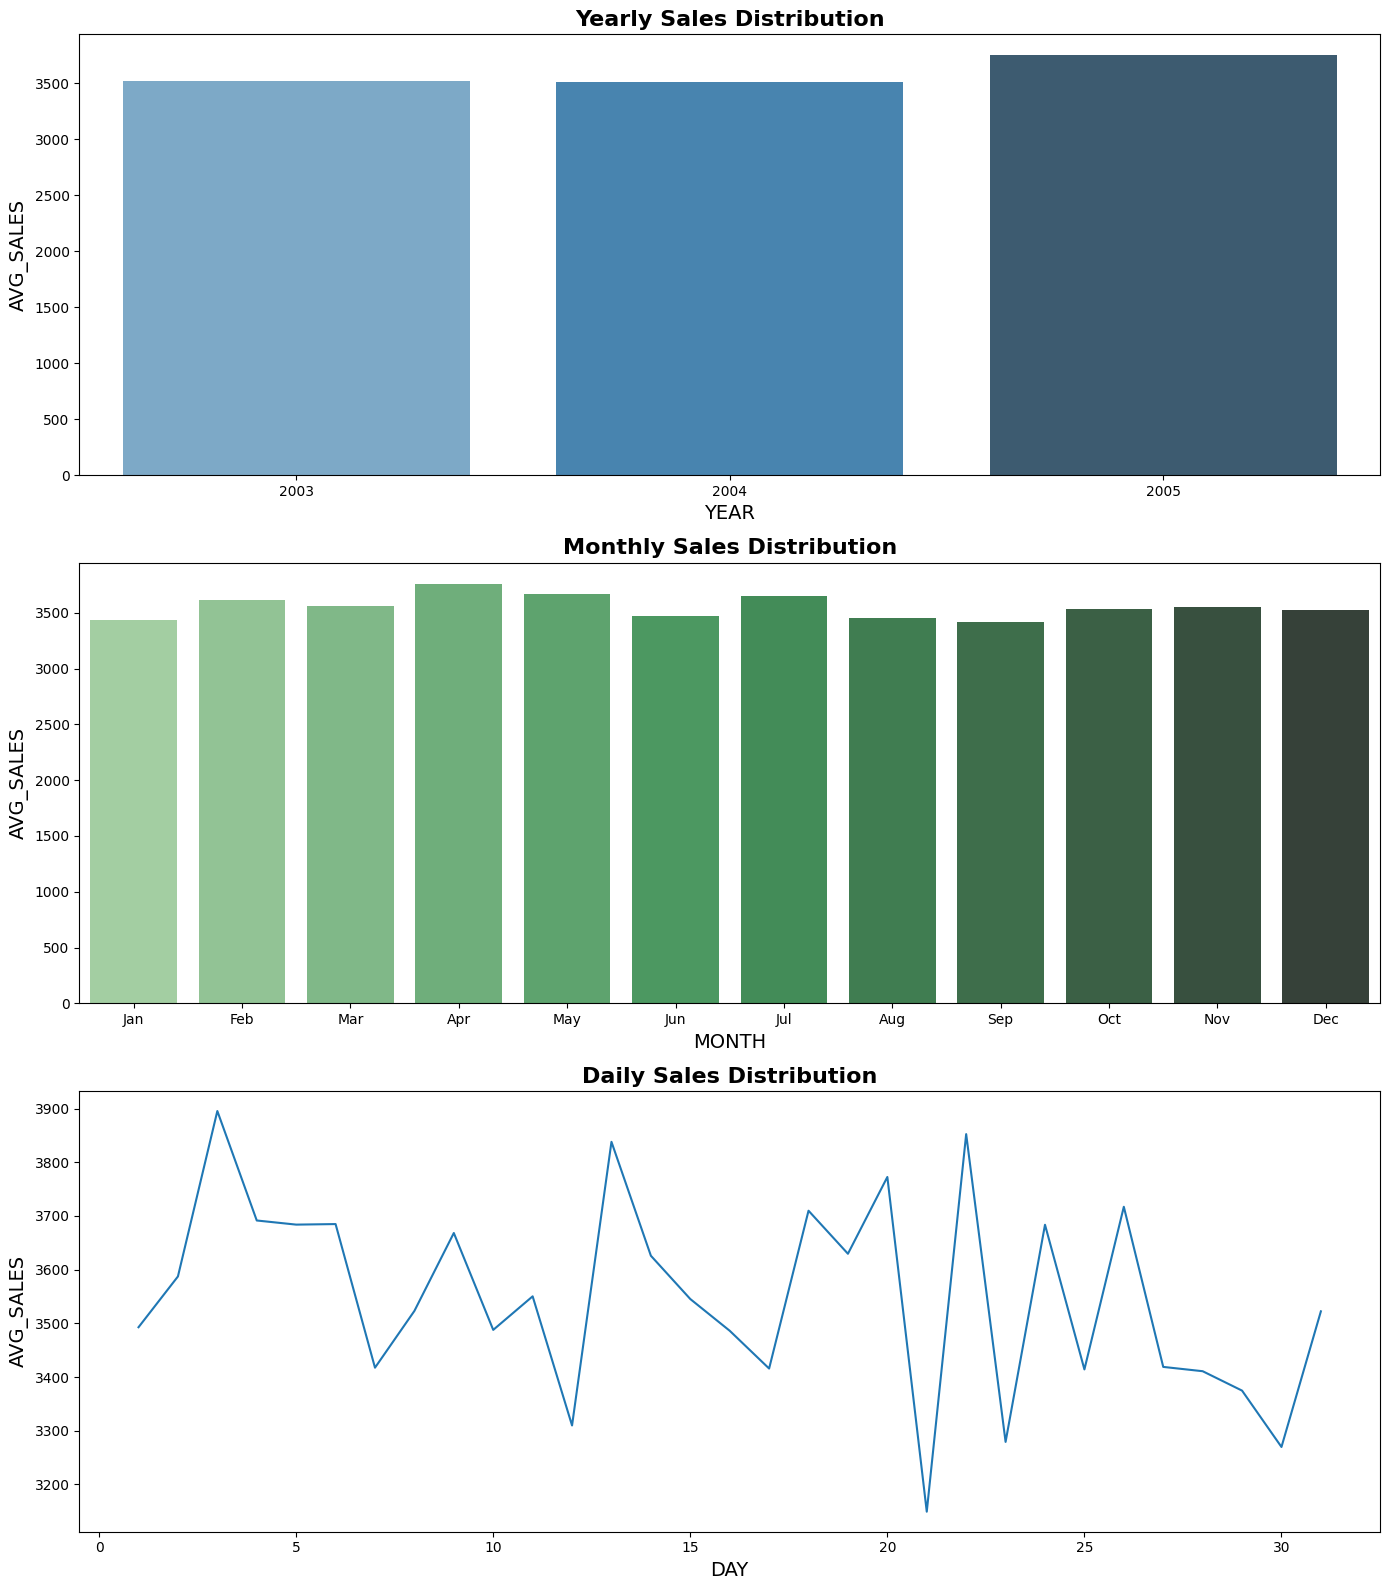

In [ ]:
#YEARLY
yearly_sales= df_saling_record.groupby(df_saling_record['sale_year'])['SALES'].mean().reset_index()
yearly_sales.columns=['YEAR','AVG_SALES']

#MONTLY
monthly_sales= df_saling_record.groupby(df_saling_record['sale_month'])['SALES'].mean().reset_index()
monthly_sales.columns=['MONTH','AVG_SALES']

#DAILY
daily_sales= df_saling_record.groupby(df_saling_record['sale_day'])['SALES'].mean().reset_index()
daily_sales.columns=['DAY','AVG_SALES']

fig, axes = plt.subplots(3, 1, figsize=(14, 16), tight_layout=True)

#YEARLY SALES PLOT
sns.barplot(ax=axes [0], data=yearly_sales, x='YEAR', y='AVG_SALES',palette='Blues_d')
axes[0].set_title('Yearly Sales Distribution', fontsize=16, weight='bold')
axes[0].set_xlabel('YEAR', fontsize=14)
axes[0].set_ylabel('AVG_SALES', fontsize=14)

#MONTLY SALES PLOT
sns.barplot(ax=axes [1], data=monthly_sales, x='MONTH', y='AVG_SALES',palette='Greens_d')
axes[1].set_title('Monthly Sales Distribution', fontsize=16, weight='bold')
axes[1].set_xlabel('MONTH', fontsize=14)
axes[1].set_ylabel('AVG_SALES', fontsize=14)
axes[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

#DAILY SALES PLOT
sns.lineplot(ax=axes [2], data=daily_sales, x='DAY', y='AVG_SALES',palette='Oranges')
axes[2].set_title('Daily Sales Distribution', fontsize=16, weight='bold')
axes[2].set_xlabel('DAY', fontsize=14)
axes[2].set_ylabel('AVG_SALES', fontsize=14)

plt.show()

# YEARLY SALES FORECASTING

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


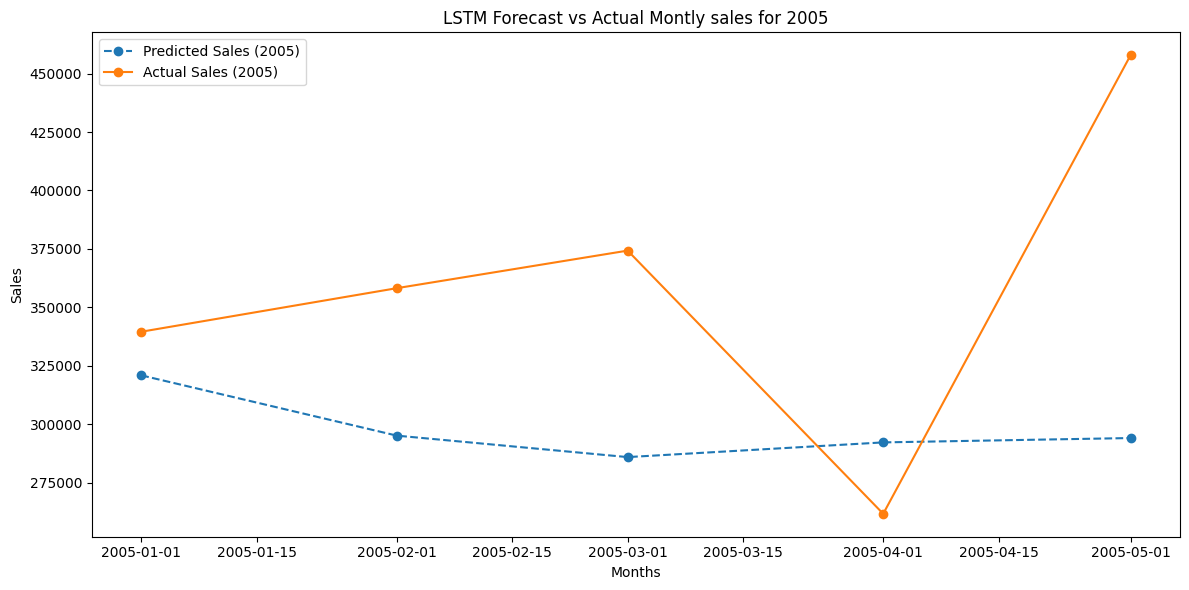

In [ ]:
df['ORDERDATE']= pd.to_datetime(df['ORDERDATE'])
df['YearMonth']=df['ORDERDATE'].dt.to_period('M').astype(str)

monthly_sales= df.groupby(df['YearMonth'])['SALES'].sum().reset_index()
monthly_sales['YearMonth']= pd.to_datetime(monthly_sales['YearMonth'])

monthly_sales=monthly_sales.sort_values('YearMonth').reset_index(drop=True)

scaler=MinMaxScaler()
sales_scaled= scaler.fit_transform(monthly_sales[['SALES']])

#create LSTM sequence
def create_sequences(data, seq_length):
  X,y= [],[]
  for i in range(len(data)-seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(X), np.array(y)
seq_length=12
X,y= create_sequences(sales_scaled, seq_length)

split_index_monthly_sales=monthly_sales[monthly_sales['YearMonth'].dt.year==2005].index.min()
split_index_xy = split_index_monthly_sales - seq_length
X_train, y_train= X[:split_index_xy], y[:split_index_xy]
X_test, y_test= X[split_index_xy:], y[split_index_xy:]

#build LSTM
model= Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=300, verbose=0)

y_pred_scaled= model.predict(X_test)
y_pred= scaler.inverse_transform(y_pred_scaled)
y_actual= scaler.inverse_transform(y_test)

predicted_dates = monthly_sales['YearMonth'][split_index_monthly_sales:split_index_monthly_sales + len(y_test)]

forecast_df= pd.DataFrame({'Date':predicted_dates, 'Predicted_Sales':y_pred.flatten(), 'Actual_Sales':y_actual.flatten()})


#plot result
plt.figure(figsize=(12,6))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Sales'], label='Predicted Sales (2005)', marker='o', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Actual_Sales'], label='Actual Sales (2005)', marker='o')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.title('LSTM Forecast vs Actual Montly sales for 2005')
plt.legend()
plt.tight_layout()
plt.show()

# Daily Sales Import

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step


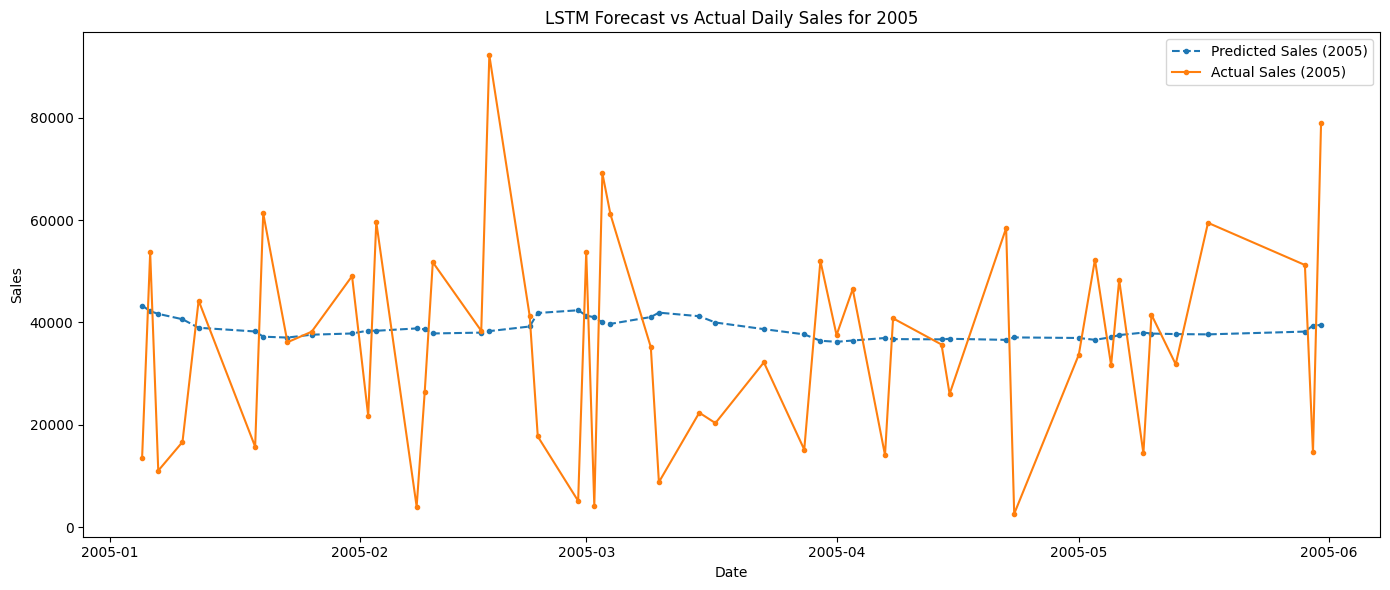

In [ ]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()
daily_sales = daily_sales.sort_values('ORDERDATE').reset_index(drop=True)

scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales[['SALES']])

#Create LSTM sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(sales_scaled, seq_length)

split_index_daily_sales = daily_sales[daily_sales['ORDERDATE'].dt.year == 2005].index.min()
split_index_xy = split_index_daily_sales - seq_length
X_train, y_train = X[:split_index_xy], y[:split_index_xy]
X_test, y_test = X[split_index_xy:], y[split_index_xy:]

#  Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, verbose=0)

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

predicted_dates = daily_sales['ORDERDATE'][split_index_daily_sales:split_index_daily_sales + len(y_test)]

forecast_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted_Sales': y_pred.flatten(),
    'Actual_Sales': y_actual.flatten()
})

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Sales'], label='Predicted Sales (2005)', linestyle='--', marker='o', markersize=3)
plt.plot(forecast_df['Date'], forecast_df['Actual_Sales'], label='Actual Sales (2005)', marker='o', markersize=3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LSTM Forecast vs Actual Daily Sales for 2005')
plt.legend()
plt.tight_layout()
plt.show()
